### Notebook to plot time series of various volume-integrated quantiteis for the base case. 

Comparisons with the unforce case are shown as well

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore") #supress warnings 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot as plt, patches

In [2]:
paths = ['/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zero_dt_30_60d_avg.nc',
         '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_avg.nc']
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,721))
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

In [3]:
def energy_alt(ds,grid,etaslice,xislice):
    '''
Modifies volume-integrated eddy, mean, and total kinetic energy modified from Hetland (2017) JPO.
Notes:
------
EKE = 1/2(uprime^2 + v^2). 
MKE = 1/2(ubar^2+vbar^2)
TKE = 1/2(u^2+v^2)
u = ubar+uprime, ubar = 1/L int_0^L u dx, i.e., alongshore mean
v = vbar+vprime
Velocities interpolated to their respective rho points
    '''
    u = xroms.to_rho(ds.u, grid)
    urho = u.isel(eta_rho = etaslice, xi_rho = xislice) 
    v = xroms.to_rho(ds.v, grid)
    vrho = v.isel(eta_rho = etaslice, xi_rho = xislice)
    
    ubar = urho.mean('xi_rho')
    uprime = urho-ubar
    
    vbar = vrho.mean('xi_rho')
    vprime = vrho-vbar
    
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    #Mean kinetic energy
    mke = 0.5*(ubar**2+vbar**2)
    mke_int = (mke*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mke_initial = (mke*dV).sum(['eta_rho', 'xi_rho', 's_rho'])[0] # Initial value for normalization
    mke_int.attrs = ''
    mke_int.name = 'mke'
    mke_initial.attrs = ''
    mke_initial.name = 'mke_initial'

    #Eddy kinetic energy
    eke = 0.5*(uprime**2 + vprime**2)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    eke_int.attrs = ''
    eke_int.name = 'eke'

    #Total kinetic energy 
    tke = 0.5*(urho**2+vrho**2)
    tke_int = (tke*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    tke_int.attrs = ''
    tke_int.name = 'tke'     
    
    dse_alt = xr.merge([eke_int, mke_initial, mke_int, tke_int])
    return dse_alt

etaslice = slice(1,100)
xislice = slice(1,-1) #Remove boundary point

dse_zero_alt = energy_alt(ds[0],grid[0],etaslice,xislice)
dse_zerop1_alt = energy_alt(ds[1],grid[1],etaslice,xislice)

#Print the initial MKE for both simulations as a QC check
# print(dse_zerop1.mke_initial.values, dse_zerop1.mke_initial.values)

In [5]:
# dse_zero_alt.to_netcdf('outputs/shelf_dx_500_mpdata_uwind_osc_zero_dt_30_ene_alt1.nc')
# dse_zerop1_alt.to_netcdf('outputs/shelf_dx_500_mpdata_uwind_osc_zeropt1_dt_30_ene_alt1.nc')

dse_zero_alt = xr.open_dataset('../figures_draft1/outputs/shelf_dx_500_mpdata_uwind_osc_zero_dt_30_ene_alt1.nc')
dse_zerop1_alt = xr.open_dataset('../figures_draft1/outputs/shelf_dx_500_mpdata_uwind_osc_zeropt1_dt_30_ene_alt1.nc')

In [6]:
def cal_vint_mixing(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice) #Destruction of salt variance
    #Interpolate to the s-rho points 
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int.name = 'mphy_int'

    ds_mix = xr.merge([mnum_int, mphy_int])
    return ds_mix

# dsm_zero = cal_vint_mixing(ds[0],grid[0],etaslice,xislice)
# dsm_zerop1 = cal_vint_mixing(ds[1],grid[1],etaslice,xislice)

# dsm_zero.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_mix.nc')
# dsm_zerop1.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_mix.nc')

dsm_zero = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_mix.nc')
dsm_zerop1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_mix.nc')

In [7]:
def cal_zint_mixing(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int.name = 'mphy_int'

    ds_zmix = xr.merge([mnum_int, mphy_int])
    return ds_zmix

# dszm_zero_top1m = cal_zint_mixing(ds[0],grid[0],etaslice,xislice)
# dszm_zerop1_top1m = cal_zint_mixing(ds[1],grid[1],etaslice,xislice)

# dszm_zero_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_top1m_dt_30_mix.nc')
# dszm_zerop1_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_top1m_dt_30_mix.nc')

dszm_zero_top1m = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_top1m_dt_30_mix.nc')
dszm_zerop1_top1m = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_top1m_dt_30_mix.nc')

In [22]:
def cal_mld_mixing(ds, grid, etaslice, xislice, mld):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mphy_int.name = 'mphy_int'

    ds_mmix = xr.merge([mnum_int, mphy_int])
    return ds_mmix

#Sensitivity study - increasing delta rho will deepend the MLD 
#------------------

#0.03 kg/m^4 cutoff
# dsm_zero_mld_03 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto3)
# dsm_zerop1_mld_03 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto3)

# dsm_zero_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto3_dt_30_mix.nc')
# dsm_zerop1_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto3_dt_30_mix.nc')

# #0.04 kg/m^4 cutoff
# dsm_zero_mld_04 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto4)
# dsm_zerop1_mld_04 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto4)

# dsm_zero_mld_04.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto4_dt_30_mix.nc')
# dsm_zerop1_mld_04.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto4_dt_30_mix.nc')

# #0.05 kg/m^4 cutoff
# dsm_zero_mld_05 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto5)
# dsm_zerop1_mld_05 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto5)

# dsm_zero_mld_05.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto5_dt_30_mix.nc')
# dsm_zerop1_mld_05.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto5_dt_30_mix.nc')

In [8]:
dsm_zero_mld_03 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto3_dt_30_mix.nc')
dsm_zerop1_mld_03 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto3_dt_30_mix.nc')

In [9]:
def svar_whole(ds, grid, xislice, etaslice):
    ''' 
Returns the three volume-averaged terms for the decomposition of salinity variance: 
total, vertical, and horizontal variance. See Li et al. (2018) JPO for details.
Inputs:
----
ds: DataArray
salt: DataArray
Outputs:
----
svar: total salinity variance
svert: vertical salinity variance
shorz: horizontal salinity variance
    '''
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['s_rho', 'xi_rho', 'eta_rho'])
    
    sbar = (1/V)*((salt*dV).sum(['xi_rho', 'eta_rho','s_rho']))
    sp_tot = (1/V)*((((salt-sbar)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    return sp_tot.load()

# svar_zero = svar_whole(ds[0], grid[0], xislice, etaslice)
# svar_zerop1 = svar_whole(ds[1], grid[1], xislice, etaslice)
# svar_zero.attrs = ''
# svar_zero.name = 'svar'
# svar_zerop1.attrs = ''
# svar_zerop1.name = 'svar'

# svar_zero.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar.nc')
# svar_zerop1.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar.nc')

svar_zero = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar.nc')
svar_zerop1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar.nc')

### Redo this - but also add the vertical and horizontal components 

In [10]:
def sprime2_whole(ds, grid, xislice, etaslice):
    ''' 
Returns the volume-averaged terms for the decomposition of salinity variance: 
total, vertical, and horizontal variance. See Li et al. (2018) JPO for details.
Inputs:
----
ds: DataArray
salt: DataArray
Outputs:
----
svar: total salinity variance
svert: vertical salinity variance
shorz: horizontal salinity variance
    '''
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['s_rho', 'xi_rho', 'eta_rho'])
    
    sbar = (1/V)*((salt*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    sp_tot = (1/V)*((((salt-sbar)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    # Now compute the local vertical salinity variance
    dz = ds.dz.isel(eta_rho = etaslice, xi_rho = xislice)
    Z = dz.sum(['s_rho'])
    sbar_z = (1/Z)*((salt*dz).sum(['s_rho']))
    sp_vert = (1/V)*((((salt-sbar_z)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    sp_horz = (sp_tot-sp_vert)
    
    sp_tot.attrs = ''
    sp_tot.name = 'svar_tot'
    sp_vert.attrs = ''
    sp_vert.name = 'svar_vert'
    sp_horz.attrs = ''
    sp_horz.name = 'svar_horz'
    
    svar_da = xr.merge([sp_tot, sp_vert, sp_horz])
    
    return svar_da

# svar = []
# for i in range(len(paths)):
#     svar_da = sprime2_whole(ds[i], grid[i], xislice, etaslice)
#     svar.append(svar_da)
    
# svar[0].to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar_decomposed.nc')
# svar[1].to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar_decomposed.nc')

In [11]:
svar_zero = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar_decomposed.nc')
svar_zerop1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar_decomposed.nc')

### Add in mixing per unit volume to compare 

In [12]:
def mixing_pervol(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['eta_rho','xi_rho','s_rho'])
    
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mphy_int.attrs = []
    mtot = mnum+mphy 
    mtot_int = (mtot*dV).sum(['eta_rho','xi_rho','s_rho'])
    mtot_int.attrs = ''

    mnum_pervol = (mnum_int/V)
    mnum_pervol.name = 'mnum'
    mphy_pervol = (mphy_int/V)
    mphy_pervol.name = 'mphy'
    mtot_pervol = (mtot_int/V)
    mtot_pervol.name = 'mtot'
    
    ds_mix = xr.merge([mnum_pervol, mphy_pervol, mtot_pervol])
    return ds_mix

def mld_mixing_pervol(ds, grid, etaslice, xislice, mld):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['eta_rho','xi_rho','s_rho'])
    
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mphy_int.attrs = []
    mtot = mnum+mphy 
    mtot_int = (mtot*dV).sum(['eta_rho','xi_rho','s_rho'])
    mtot_int.attrs = ''

    mnum_pervol = (mnum_int/V)
    mnum_pervol.name = 'mnum'
    mphy_pervol = (mphy_int/V)
    mphy_pervol.name = 'mphy'
    mtot_pervol = (mtot_int/V)
    mtot_pervol.name = 'mtot'
    
    ds_mix = xr.merge([mnum_pervol, mphy_pervol, mtot_pervol])
    return ds_mix

def topm_mixing_pervol(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['eta_rho','xi_rho','s_rho'])
    
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mphy_int.attrs = []
    
    mtot = mnum+mphy 
    mtot_int = (mtot*dV).sum(['eta_rho','xi_rho','s_rho'])
    mtot_int.attrs = ''

    mnum_pervol = (mnum_int/V)
    mnum_pervol.name = 'mnum'
    mphy_pervol = (mphy_int/V)
    mphy_pervol.name = 'mphy'
    mtot_pervol = (mtot_int/V)
    mtot_pervol.name = 'mtot'

    ds_mix = xr.merge([mnum_pervol, mphy_pervol, mtot_pervol])
    return ds_mix

# dsm_zero = mixing_pervol(ds[0],grid[0],etaslice,xislice)
# dsm_zerop1 = mixing_pervol(ds[1],grid[1],etaslice,xislice)

# dsm_zero.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_pervol_dt_30_mix.nc')
# dsm_zerop1.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_pervol_dt_30_mix.nc')

# dsm_zero_mld_03 = mld_mixing_pervol(ds[0],grid[0],etaslice,xislice,mld0_zeropto3)
# dsm_zerop1_mld_03 = mld_mixing_pervol(ds[1],grid[1],etaslice,xislice,mld1_zeropto3)

# dsm_zero_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mldpervol_zeropto3_dt_30_mix.nc')
# dsm_zerop1_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mldpervol_zeropto3_dt_30_mix.nc')

# dszm_zero_top1m = topm_mixing_pervol(ds[0],grid[0],etaslice,xislice)
# dszm_zerop1_top1m = topm_mixing_pervol(ds[1],grid[1],etaslice,xislice)

# dszm_zero_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_top1mpervol_dt_30_mix.nc')
# dszm_zerop1_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_top1mpervol_dt_30_mix.nc')

In [13]:
dsm_zero_pervol = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_pervol_dt_30_mix.nc')
dsm_zerop1_pervol = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_pervol_dt_30_mix.nc')

dsm_zero_mld_03_pervol= xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_mldpervol_zeropto3_dt_30_mix.nc')
dsm_zerop1_mld_03_pervol = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_mldpervol_zeropto3_dt_30_mix.nc')

dszm_zero_top1m_pervol = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zero_top1mpervol_dt_30_mix.nc')
dszm_zerop1_top1m_pervol = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/figures_draft1/outputs/shelf_dx_500_uwind_mpdata_osc_zeropt1_top1mpervol_dt_30_mix.nc')

### Prepare for plotting by:
> - Opening history file of forcing so values aren't biased by averaging
> - creating a time vector 

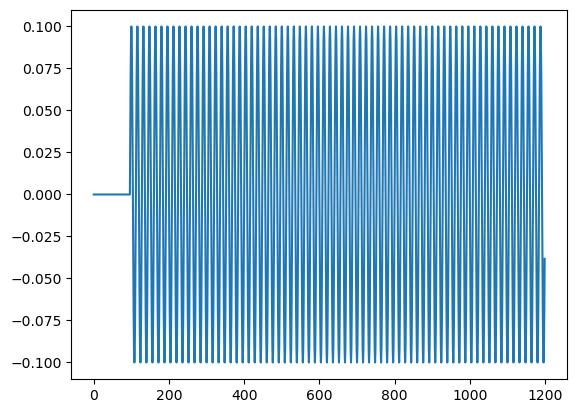

In [14]:
ds_his = xr.open_dataset('/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_his.nc')
plt.plot(ds_his.sustr[0:-1,0,0])

In [15]:
time = np.arange(0,len(ds[1].ocean_time))/24 
print(time[180:361][0],time[180:361][-1])

### Plot the data 

In [16]:
plt.rcParams.update({'font.size': 10})

In [17]:
mtot_zerop1 = dsm_zerop1.mnum_int+dsm_zerop1.mphy_int
mtot_zero = dsm_zero.mnum_int+dsm_zero.mphy_int

mtot_zerop1_z1 = dszm_zerop1_top1m.mnum_int+dszm_zerop1_top1m.mphy_int
mtot_zero_z1 = dszm_zero_top1m.mnum_int+dszm_zero_top1m.mphy_int

mtot_zerop1_zmld = dsm_zerop1_mld_03.mnum_int+dsm_zerop1_mld_03.mphy_int
mtot_zero_zmld = dsm_zero_mld_03.mnum_int+dsm_zero_mld_03.mphy_int

In [20]:
print('Whole', "{:.1f}".format((dsm_zerop1.mnum_int[180:361].sum().values)/(dsm_zerop1.mphy_int[180:361].sum().values)*100))
print('Whole', "{:.1f}".format((dsm_zero.mnum_int[180:361].sum().values)/(dsm_zero.mphy_int[180:361].sum().values)*100))

print('Top1m:', "{:.1f}".format((dszm_zerop1_top1m.mnum_int[180:361].sum().values)/(dszm_zerop1_top1m.mphy_int[180:361].sum().values)*100))
print('Top1m:', "{:.1f}".format((dszm_zero_top1m.mnum_int[180:361].sum().values)/(dszm_zero_top1m.mphy_int[180:361].sum().values)*100))

print('MLD:', "{:.1f}".format((dsm_zerop1_mld_03.mnum_int[180:361].sum().values)/(dsm_zerop1_mld_03.mphy_int[180:361].sum().values)*100))
print('MLD:', "{:.1f}".format((dsm_zero_mld_03.mnum_int[180:361].sum().values)/(dsm_zero_mld_03.mphy_int[180:361].sum().values)*100))

print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zerop1_mld_03.mnum_int[180:361].sum().values)/(dsm_zerop1.mnum_int[180:361].sum().values)*100))
print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zero_mld_03.mnum_int[180:361].sum().values)/(dsm_zero.mnum_int[180:361].sum().values)*100))

print('MLD/whole, Mnum:', "{:.1f}".format((dsm_zerop1_mld_03.mphy_int[180:361].sum().values)/(dsm_zerop1.mphy_int[180:361].sum().values)*100))
print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zero_mld_03.mphy_int[180:361].sum().values)/(dsm_zero.mphy_int[180:361].sum().values)*100))

Whole 15.4
Whole 6.5
Top1m: 210.8
Top1m: 104.8
MLD: 49.3
MLD: 24.9
MLD/whole, Mphy: 16.5
MLD/whole, Mphy: 10.0
MLD/whole, Mnum: 5.1
MLD/whole, Mphy: 2.6


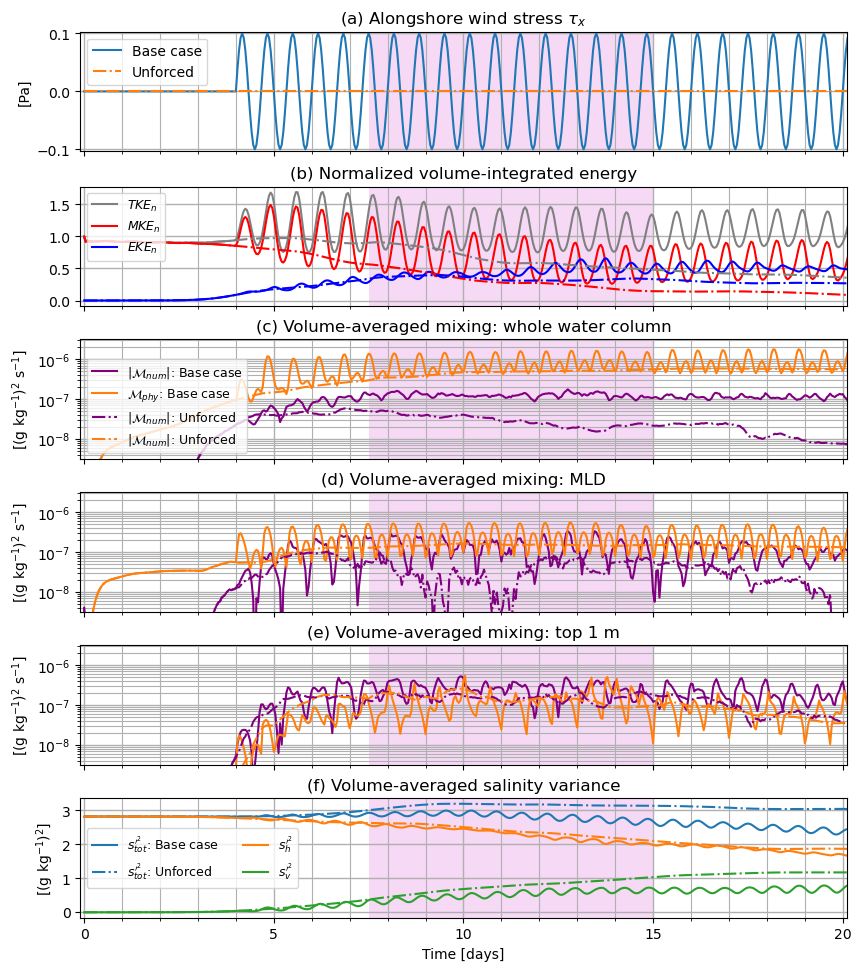

In [24]:
nrows = 6; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,(6/3.75)*nrows), constrained_layout = True, sharex = True)

time = time[:721]
ax[0].plot(time,ds_his.sustr[:721,0,0], label = 'Base case')
ax[0].plot(time,ds_his.sustr[:721,0,0]*0, ls = 'dashdot', label = 'Unforced')
ax[0].set_xlabel('')
ax[0].set_ylabel(r'[Pa]')
ax[0].set_ylim(-0.103,.103)
ax[0].set_title(r'(a) Alongshore wind stress $\tau_x$')
ax[0].legend(loc = 'upper left')

ax[1].plot(time, dse_zerop1_alt.tke[:721]/dse_zerop1_alt.mke_initial, color = 'gray', label = r'$TKE_n$')
ax[1].plot(time, dse_zerop1_alt.mke[:721]/dse_zerop1_alt.mke_initial, color = 'r', label = r'$MKE_n$')
ax[1].plot(time, dse_zerop1_alt.eke[:721]/dse_zerop1_alt.mke_initial, color = 'b', label = r'$EKE_n$')
ax[1].plot(time, dse_zero_alt.tke[:721]/dse_zero_alt.mke_initial, color = 'gray', ls = 'dashdot')
ax[1].plot(time, dse_zero_alt.mke[:721]/dse_zero_alt.mke_initial, color = 'r', ls = 'dashdot')
ax[1].plot(time, dse_zero_alt.eke[:721]/dse_zero_alt.mke_initial, color = 'b', ls = 'dashdot')

ax[1].set_title('(b) Normalized volume-integrated energy')
ax[1].legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax[2].semilogy(time, np.abs(dsm_zerop1_pervol.mnum), color = 'purple', label = r'$|\mathcal{M}_{num}|$: Base case')
ax[2].semilogy(time, dsm_zerop1_pervol.mphy, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$: Base case')
ax[2].semilogy(time, np.abs(dsm_zero_pervol.mnum), color = 'purple', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')
ax[2].semilogy(time, dsm_zero_pervol.mphy, color = 'tab:orange', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')

ax[2].set_title('(c) Volume-averaged mixing: whole water column')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax[2].set_ylim(10**-8.5,10**-5.5)
ax[2].legend(loc = 'lower left', ncol = 1, fontsize = 9)
ax[2].yaxis.get_major_locator().set_params(numticks=99)
ax[2].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])

ax[3].semilogy(time, np.abs(dsm_zerop1_mld_03_pervol.mnum), color = 'purple', label = r'$|\mathcal{M}_{num}|$: Base case')
ax[3].semilogy(time, dsm_zerop1_mld_03_pervol.mphy, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$: Base case')
ax[3].semilogy(time, np.abs(dsm_zero_mld_03_pervol.mnum), color = 'purple', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')
ax[3].semilogy(time, dsm_zero_mld_03_pervol.mphy, color = 'tab:orange', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')

ax[3].set_ylabel(r'[(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax[3].set_ylim(10**-8.5,10**-5.5)
ax[3].set_title('(d) Volume-averaged mixing: MLD')
ax[3].yaxis.get_major_locator().set_params(numticks=99)
# ax[3].legend(loc = 'upper left', ncol = 1)

ax[4].semilogy(time, np.abs(dszm_zerop1_top1m_pervol.mnum), color = 'purple', label = r'$|\mathcal{M}_{num}|$')
ax[4].semilogy(time, dszm_zerop1_top1m_pervol.mphy, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$')
ax[4].semilogy(time, np.abs(dszm_zero_top1m_pervol.mnum), color = 'purple', ls = 'dashdot')
ax[4].semilogy(time, dszm_zero_top1m_pervol.mphy, color = 'tab:orange', ls = 'dashdot')

ax[4].set_ylabel(r'[(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax[4].set_ylim(10**-8.5,10**-5.5)
ax[4].set_title('(e) Volume-averaged mixing: top 1 m')
ax[4].yaxis.get_major_locator().set_params(numticks=99)
# ax[4].legend(loc = 'upper left', ncol = 1)

ax[5].plot(time, svar_zerop1.svar_tot[:721], color = 'tab:blue', label = r'$s_{tot}^{\prime^2}$: Base case')
ax[5].plot(time, svar_zero.svar_tot[:721], color = 'tab:blue', ls = 'dashdot', label = r'$s_{tot}^{\prime^2}$: Unforced')
ax[5].plot(time, svar_zerop1.svar_horz[:721], color = 'tab:orange', label = r'$s_{h}^{\prime^2}$')
ax[5].plot(time, svar_zero.svar_horz[:721], color = 'tab:orange', ls = 'dashdot')
ax[5].plot(time, svar_zerop1.svar_vert[:721], color = 'tab:green', label = r'$s_{v}^{\prime^2}$')
ax[5].plot(time, svar_zero.svar_vert[:721], color = 'tab:green', ls = 'dashdot')
ax[5].set_xlabel('Time [days]')
ax[5].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[5].set_title('(f) Volume-averaged salinity variance')
ax[5].legend(loc = 'center left', ncol = 2, fontsize = 9)

for i in range(nrows):
    ax[i].set_xlim(-0.1,20.1)
    ax[i].set_xticks(np.arange(0,25,5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which = 'major', lw = 1)
    ax[i].grid(which = 'minor')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[0].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[1].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[2].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[3].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[4].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[5].add_patch(rectangle)

import matplotlib.ticker

locmin = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(2, 10.0) * 0.1, numticks = 10) 
ax[3].yaxis.set_minor_locator(locmin)
ax[3].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[4].yaxis.set_minor_locator(locmin)
ax[4].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# 
plt.savefig('time_series_shelf_overview_vavg.png', dpi = 300, bbox_inches='tight')